In [1]:
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

DATASET = 'british_outlets'

In [2]:
tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()

In [3]:
# Readlines into list of tweets and labels
with open('..\\dataset_creation\\datasets\\'+DATASET+'\\tweets.txt', encoding="utf8") as f:
    raw_tweets = f.readlines()

with open('..\\dataset_creation\\datasets\\'+DATASET+'\\labels.txt')as f:
    raw_labels = f.readlines()

# Create list of output targets
target_dataset = list()
for label in raw_labels:
    if label == '1\n':
        target_dataset.append(1)
    else:
        target_dataset.append(0)

# 
SPLIT = round(len(raw_tweets)*0.1)

In [4]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 240)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    y_batch = tf.convert_to_tensor(y_batch, dtype=tf.int64)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [5]:
X_batch, y_batch = preprocess(raw_tweets, target_dataset)

In [6]:
X_test, X_train_full = X_batch[:SPLIT], X_batch[SPLIT:]
y_test, y_train_full = y_batch[:SPLIT], y_batch[SPLIT:]

In [7]:
vocabulary = Counter()
for tweet in X_train_full:
    vocabulary.update(list(tweet.numpy()))

In [8]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]
]

In [9]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [10]:
def encode_words(dataset_input):
    return table.lookup(dataset_input)

In [11]:
X_valid, X_train = encode_words(X_train_full[:SPLIT]), encode_words(X_train_full[SPLIT:])
y_valid, y_train = y_train_full[:SPLIT], y_train_full[SPLIT:]

In [12]:
embed_size = X_batch.shape[1]
dropout = 0.5
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, mask_zero=True),
    keras.layers.Dropout(dropout),
    keras.layers.GRU(256),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(1, activation="sigmoid")
])

In [13]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 61)          671000    
_________________________________________________________________
dropout (Dropout)            (None, None, 61)          0         
_________________________________________________________________
gru (GRU)                    (None, 256)               244992    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 916,249
Trainable params: 916,249
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Train on 137600 samples, validate on 17200 samples
Epoch 1/10
137600/137600 [==============================] - 455s 3ms/sample - loss: 0.2767 - accuracy: 0.8735 - val_loss: 0.2146 - val_accuracy: 0.9015
Epoch 2/10
137600/137600 [==============================] - 813s 6ms/sample - loss: 0.1886 - accuracy: 0.9152 - val_loss: 0.2013 - val_accuracy: 0.9096
Epoch 3/10
137600/137600 [==============================] - 1371s 10ms/sample - loss: 0.1626 - accuracy: 0.9271 - val_loss: 0.1991 - val_accuracy: 0.9066
Epoch 4/10
137600/137600 [==============================] - 1958s 14ms/sample - loss: 0.1436 - accuracy: 0.9363 - val_loss: 0.2080 - val_accuracy: 0.9088
Epoch 5/10
137600/137600 [==============================] - 2575s 19ms/sample - loss: 0.1288 - accuracy: 0.9427 - val_loss: 0.2142 - val_accuracy: 0.9101
Epoch 6/10
137600/137600 [==============================] - 3191s 23ms/sample - loss: 0.1176 - accuracy: 0.9476 - val_loss: 0.2153 - val_accuracy: 0.9097
Epoch 7/10
137600/137600 [===

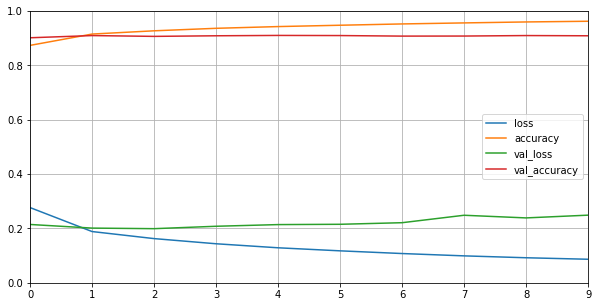

In [16]:
# Represent learning curves using pandas and matplotlib
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(0, 9)
plt.show()

In [17]:
X_test_encoded = encode_words(X_test)

In [18]:
model.evaluate(X_test_encoded, y_test)

17200/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.2473772611720271, 0.9089535]

In [19]:
X_new = X_test_encoded[:10]
y_proba = model.predict(X_new)
for i in range(len(y_proba)):
    print(str(i+1) + ".\nPrediction: " + str(y_proba[i][0].round(2)) + "\nActual: " + str(y_test[i].numpy()) + "\n")

1.
Prediction: 1.0
Actual: 1

2.
Prediction: 0.17
Actual: 0

3.
Prediction: 1.0
Actual: 1

4.
Prediction: 0.35
Actual: 0

5.
Prediction: 0.0
Actual: 0

6.
Prediction: 0.13
Actual: 0

7.
Prediction: 1.0
Actual: 1

8.
Prediction: 0.0
Actual: 0

9.
Prediction: 0.0
Actual: 0

10.
Prediction: 0.01
Actual: 0



In [20]:
model.save(DATASET + '.h5')

In [21]:
new_model = keras.models.load_model(DATASET + '.h5')

In [22]:
X_new = X_test_encoded[:10]
new_y_proba = new_model.predict(X_new)
for i in range(len(new_y_proba)):
    print(str(i+1) + ".\nPrediction: " + str(new_y_proba[i][0].round(2)) + "\nActual: " + str(y_test[i].numpy()) + "\n")

1.
Prediction: 1.0
Actual: 1

2.
Prediction: 0.17
Actual: 0

3.
Prediction: 1.0
Actual: 1

4.
Prediction: 0.35
Actual: 0

5.
Prediction: 0.0
Actual: 0

6.
Prediction: 0.13
Actual: 0

7.
Prediction: 1.0
Actual: 1

8.
Prediction: 0.0
Actual: 0

9.
Prediction: 0.0
Actual: 0

10.
Prediction: 0.01
Actual: 0

